# Customer Analysis with KMeans Clustering, Gaussian Mixtures, and PCA

The goal here is to determine customer segments with the goal of determining who should be targeted with advertisements. Although I can't find explicit mention of this, I'm assuming this data is from a wine store since amount of money spent on wine is highly correlated with total money spent. 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse as Ellipse

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

import warnings
import sys
import os

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
    
np.random.seed(73)

## Data Processing

In [85]:
DATA_PATH = os.path.join('C:\\', '_local', 'data_sets', 'business', 'marketing_campaign.csv')

df_raw = pd.read_csv(
    DATA_PATH, sep='\t', parse_dates=['Dt_Customer'], infer_datetime_format=True
)

In [86]:
print(f'data shape: {df_raw.shape}')
df_raw.head()

data shape: (2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0000,0,0,2012-04-09,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0000,1,1,2014-08-03,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0000,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0000,1,0,2014-10-02,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0000,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [87]:
# Get age of customer the last time they came to the store
df_raw['Customer_Age'] = df_raw['Dt_Customer'].dt.year - df_raw['Year_Birth']
df_raw = df_raw[df_raw['Customer_Age'] <= 100] # Apparently there were some 120 year olds going to buy wine

In [88]:
# Get household size data

# Number of people in household implied by marital status
marital_household_size_dict = {
    'Single': 1, 'Divorced': 1, 'Widow': 1, 'Alone': 1,
    'Absurd': 1, 'YOLO': 1, 'Together': 2, 'Married': 2
}

# Get whether customer is single
df_raw['Single'] = (df_raw['Marital_Status']
                    .isin(['Single', 'Divorced', 'Widow', 'Alone', 'Absurd', 'YOLO'])
                    .astype(int)
                    .map(lambda x: (x-.5)/2)
                   )

# Number of children in each customer's household
df_raw['Num_Children'] = df_raw['Kidhome'] + df_raw['Teenhome']
df_raw['Lives_With_Child'] = (df_raw['Num_Children'] > 0).astype(int).map(lambda x: (x-.5)/2)

In [89]:
# Map education to integers
df_raw['Education'] = df_raw['Education'].replace({
    'Basic': 1, '2n Cycle': 1, 
    'Graduation': 2, 'Master': 2, 'PhD': 3
})

# Map education (ordinal, discrete) to numeric variable
df_raw['Education'] = df_raw['Education'].map(lambda x: (x-.5)/3)

In [90]:
# Total number of store purchases
num_purchases_strings = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df_raw['Total_Purchases'] = df_raw[num_purchases_strings].sum(axis=1)

# Total amount of money spent in store
category_spending_strings = ['MntWines', 'MntFruits', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df_raw['Total_Spendage'] = df_raw[category_spending_strings].sum(axis=1)

# Total number of campaigns accepted
cmp_accepted_strings = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df_raw['TotalCmpAccepted'] = df_raw[cmp_accepted_strings].sum(axis=1)

# Map remaining discrete variables to numerics
df_raw['Complain'] = df_raw['Complain'].map(lambda x: (x-.5)/2)
df_raw['Response'] = df_raw['Response'].map(lambda x: (x-.5)/2)

In [91]:
# We find that only income is missing observations (24)
# df.isnull().sum()[df.isnull().sum() > 0]

df_raw = df_raw.dropna() # Since there are only 24 people with missing incomes, we will drop them from the dataset
#df_raw = df_raw[df_raw['Income'] <= 125000] # About 6 people have income >- 150000, I'll just remove them
df_raw['Income'] = df_raw['Income'].where(df_raw['Income'] < 200000, 200000) # Putting the one guy w/ 600k/year in check

df_raw = df_raw.reset_index().drop(['index'], axis=1)

In [92]:
df_raw = df_raw.drop(
    ['Marital_Status', 'Dt_Customer', 'Year_Birth', 'ID', 'Kidhome', 'Teenhome',
     'Z_CostContact', 'Z_Revenue', *cmp_accepted_strings, 'Response'
    ], axis=1
)

## Data Inspection

In [93]:
df_raw.describe().loc[['mean', 'std', 'min', 'max']]

,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Customer_Age,Single,Num_Children,Lives_With_Child,Total_Purchases,Total_Spendage,TotalCmpAccepted
mean,0.5343,52025.7067,49.0077,305.1536,26.3240,166.9625,37.6353,27.0348,43.9114,2.3254,4.0877,2.6715,5.8052,5.3217,-0.2455,44.1107,-0.0729,0.9476,0.1072,12.5644,440.0592,0.2982
std,0.1887,21751.2670,28.9419,337.3055,39.7359,224.2262,54.7633,41.0854,51.6997,1.9244,2.7417,2.9271,3.2508,2.4251,0.0473,11.7367,0.2392,0.7493,0.2259,7.2048,429.8913,0.6794
min,0.1667,1730.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.2500,16.0000,-0.2500,0.0000,-0.2500,0.0000,4.0000,0.0000
max,0.8333,200000.0000,99.0000,1493.0000,199.0000,1725.0000,259.0000,262.0000,321.0000,15.0000,27.0000,28.0000,13.0000,20.0000,0.2500,73.0000,0.2500,3.0000,0.2500,32.0000,1798.0000,4.0000


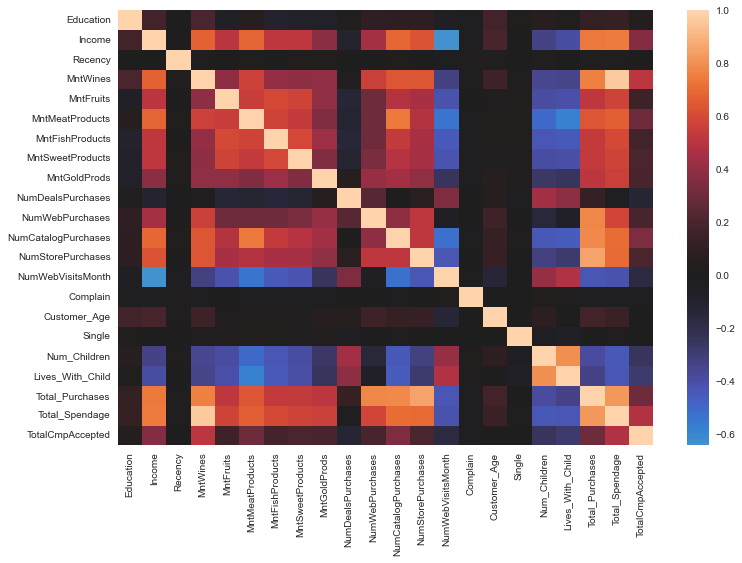

In [94]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_raw.corr(), center=0, xticklabels=True, yticklabels=True);

Upon inspection of the data's linear correlation matrix, we find the following among other things:
1. Spending between categories - e.g. fish and meat products - is highly correlated
2. Income is inversely correlated with number of web visits and number of kids
3. Income is correlated with spending in each product category except gold, and thus total spending
4. Amount spent on wine is highly correlated with total amount spent at store (this dataset may be for a wine store)
5. Money spent on wine and in total are correlated with the number of campaigns accepted
6. Recency, education, whether the customer complained, and last visit are not correlated with any other variables.
7. Number of web visits is inversely correlated with spending in each category and in total

## Defining Dissimilarity

Given a choice of metric, clustering approaches assume that the dissimilarity between points is equivalent to the distance between those points with respect to that metric. However, oftentimes the dissimilarity between 2 observations is not well-represented by the distance between those observations.

In every use case, the relative importance of variables should be determined by a combination of domain knowledge and considerations of what the analysis intends to examine. For instance, if the analysis is looking for which customers to send notifications of new wine products to, that analysis would probably benefit from a higher weighting of a customer's total wine spending.

Given the radically different scales of variables in the data, we need to specify the dissimilarity measure of clustering, otherwise variables with larger variances such as income will be (undesirably-)dominant factors in determining which cluster a customer is assigned to.

The distance between 2 points is invariant under translation (e.g., shifting each variable to mean 0), so centering each variable around 0 won't change the cluster assignment of a customer. On the other hand, a variable's relative importance in cluster assignment is proportional to its sample variance (since variance is related to the distance between 2 instances of the variable). Since variables such as income and spending have much larger standard deviations, if we don't scale them down, then clusters will basically be entirely determined by those variables.

In this notebook, I am looking to segment customers based on who should be targeted for advertisements with the goal of generating more revenue. I decided to have (disposable) income and previous spending as the primary factors in clustering. I also operate under the assumption that this data comes from a store which primarily sells wine. The standard deviations / relative importances of each variable are explicitly defined as *desired_sigmas*. I use squared distance throughout.

In [95]:
df = df_raw.copy()

df_mean, df_std = df.mean(), df.std()
desired_sigmas = [.25, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1.5, 2, 2, 3.5, 2]

def transform(data):
    assert isinstance(data, pd.core.frame.DataFrame)
    global df_mean, df_std, desired_sigmas
    
    d = (data - df_mean) / df_std
    return d * desired_sigmas

def inverse_transform(data):
    assert isinstance(data, pd.core.frame.DataFrame)
    global df_mean, df_std, desired_sigmas
    
    d = data / desired_sigmas
    return d * df_std + df_mean

df = transform(df) # Transform ith variable ~ N(0, desired_sigmas[i])

## K-Means Clustering

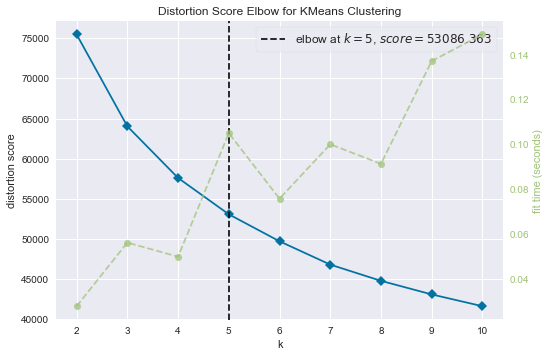

In [96]:
KElbowVisualizer(KMeans(), k=10).fit(df).show();

We observe that the distortion score (sum of euclidean distances between each point and its center) elbow (discrete analog of point of maximum curvature) is located at k = 5. This indicates that selecting k = 5 will give us best results with respect to distortion score while keeping k relatively small.

We can also fit KMeans on principal components (PCA) and see if this yields a different elbow value for k. Since the components of PCA explain a decreasing amount of the raw data's variance (but sum to the raw data's variance), and KMeans effectively minimizes the within-cluster variance for a given k, the distortion scores for each k are generally increasing with respect to the number of PCs that KMeans is fit on and converge to the distortion scores for that value of k in the original data.

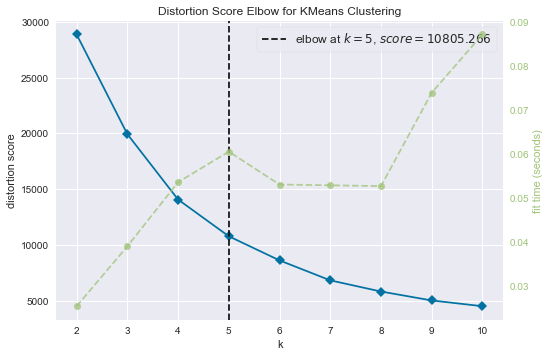

In [97]:
PCA_N_COMPONENTS = 2
pca = PCA(n_components=PCA_N_COMPONENTS).fit(df)
pca_df = pd.DataFrame(pca.transform(df), columns=[f'pc_{p}' for p in range(1, PCA_N_COMPONENTS+1)])

KElbowVisualizer(KMeans(), k=10).fit(pca_df).show();

We see that even fitting the data on only 2 PCs also yields an elbow of k = 5 (fitting with 1 and between 3 and 10 PCs all yields the same elbow).

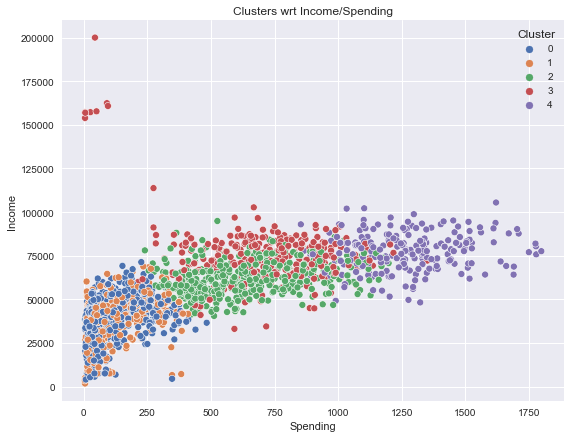

In [98]:
kmeans = KMeans(n_clusters=5).fit(df)
kmeans_preds = kmeans.predict(df)

# Sort cluster indices by center's income
clusters_income_argsort = np.argsort([cc[1] for cc in kmeans.cluster_centers_])
clusters_income_argsort_rev_map = {cluster: arg for arg, cluster in enumerate(clusters_income_argsort)}
kmeans_preds = [clusters_income_argsort_rev_map[cluster] for cluster in kmeans_preds]

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(9, 7))
sns.scatterplot(data=df_raw, x='Total_Spendage', y='Income', hue=kmeans_preds, palette='deep', ax=ax)
ax.set_title(f'Clusters wrt Income/Spending')
ax.set_ylabel('Income')
ax.set_xlabel('Spending')
ax.legend(title='Cluster')
plt.show()

In the above graph, we can consider cluster 4 as our loyal customers: these people spend the most money at our store and have the most disposable income. Since cluster 4 customers already spend a lot at our store, targeting them with advertisements may not change how much they spend here. Clusters 2 and 3 are are likely high priority customers for advertising: these people spend less than cluster 4 but have similar or much larger income, but do not spend as much at our store. Clusters 0 and 1 are low priority since they do not spend much and have lower income / spending potential.

There is some noise in the cluster assignment (with respect to income and spending) which is due to other variables. For instance, even if someone has high income and spending, if they did not respond positively to other ad campaigns (TotalCmpAccepted), then targeting them with high priority may not be productive (accordingly, weight of TotalCmpAccepted is relatively large).

It should be noted that the above graph only looks at income and spending, and not the approximately 20 other variables in the dataset. We cannot be sure that the relative distances between cluster centers is well-represented by distances between income and spending. Since the general areas of most clusters are easy to differentiate - e.g., cluster 0 clearly has less income and spending than cluster 4 - from just this graph alone we can be pretty sure that income and spending variables have significant effect in determining clustering (we also know this from their sample variances which we explicitly defined).

We can also try fitting kmeans on principal components, and seeing if the clusters have more defined boundaries with respect to the first 2 principal components (we could also do similar for 3 PCs, but I chose 2 since it is easier to visualize).

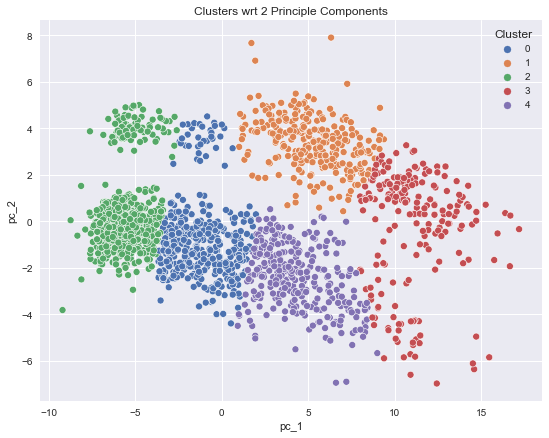

In [99]:
kmeans_pca = KMeans(n_clusters=5).fit(pca_df)
kmeans_pca_preds = kmeans_pca.predict(pca_df)

# Note the cluster numbering here does not necessarily match the previous cluster numbering
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(9, 7))
sns.scatterplot(data=pca_df, x='pc_1', y='pc_2', hue=kmeans_pca_preds, palette='deep', ax=ax)
ax.set_title(f'Clusters wrt 2 Principle Components')
ax.set_xlabel('pc_1')
ax.set_ylabel('pc_2')
ax.legend(title='Cluster')
plt.show()

With regard to the first two principal components, the boundaries between nearby clusters are still not obvious. The first 2 PCs explain about 65% of the data's total variance. The above graph indicates that the landscape of customer data is relatively smooth (at least for 2 PCs) and that the distinctive clusters that kmeans looks for may not exist in the data.

We also see a band without observations which separates 2 regions of customers, however our kmeans model did not pick up on that as separating clusters.

In [44]:
class SeabornFig2Grid():
    
    # Thanks to ImportanceOfBeingErnest on StackOverflow

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

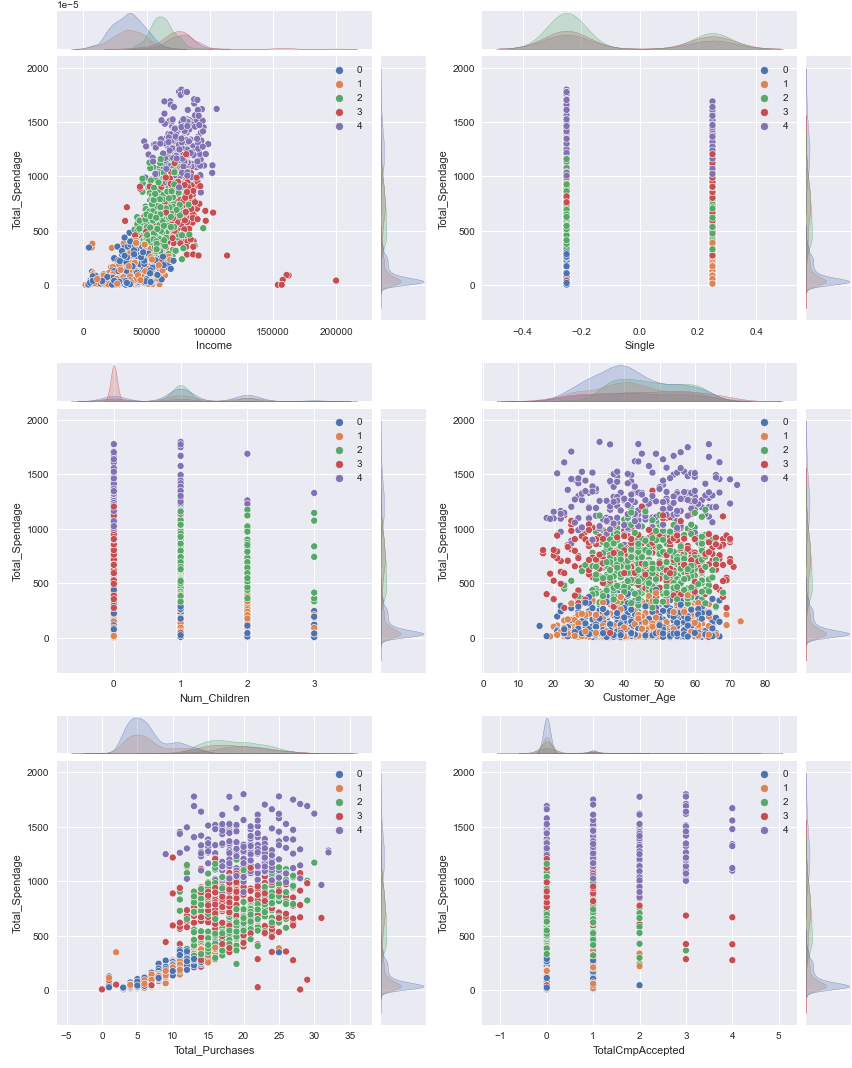

In [100]:
profiling_variables = ['Income', 'Single', 'Num_Children', 'Customer_Age', 'Total_Purchases', 'TotalCmpAccepted']

sns.set_style('darkgrid')
fig = plt.figure(figsize=(12, 15))
gs = gridspec.GridSpec(3, 2)

for g, var in enumerate(profiling_variables):  
    p = sns.jointplot(data=df_raw, x=var, y='Total_Spendage', hue=kmeans_preds, palette='deep', kind='scatter')
    SeabornFig2Grid(p, fig, gs[g])

gs.tight_layout(fig)
plt.show()

From the above plots, we can make the following conclusions about our kmeans clusters.

a) Customers in cluster 0 have the lowest income, make small and infrequent purchases, may be single or married, usually live with at less than 2 children, are typically between 30 and 40, and are the least likely to respond well to previous ad campaigns.

b) Customers in cluster 3 have high income, are single or married, almost always do not live with a child, may be of any age, make a lower total of puchases, and are more responsive to ad campaigns that cluster 0.

We can draw conclusions about the other clusters in a similar manner.

## Mixture Modelling

We can also try Guassian Mixture Models which assume that each data point is an observation from one of n latent Guassian variables.

In [101]:
mixture_n_components = 5

# Gaussian Mixture
gm = GaussianMixture(n_components=mixture_n_components, covariance_type='full').fit(df)
gm_preds = gm.predict(df)

gm_income_argsort = np.argsort([mean[1] for mean in gm.means_])
gm_income_argsort_rev_map = {cluster: arg for arg, cluster in enumerate(gm_income_argsort)}
gm_preds = [gm_income_argsort_rev_map[cluster] for cluster in gm_preds]

# BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=mixture_n_components, covariance_type='full').fit(df)
bgm_preds = bgm.predict(df)
bgm_income_argsort = np.argsort([mean[1] for mean in bgm.means_])
bgm_income_argsort_rev_map = {cluster: arg for arg, cluster in enumerate(bgm_income_argsort)}
bgm_preds = [bgm_income_argsort_rev_map[cluster] for cluster in bgm_preds]

# GaussianMixture on PCs
gm_pca = GaussianMixture(n_components=mixture_n_components, covariance_type='full').fit(pca_df)
gm_pca_preds = gm_pca.predict(pca_df)

# BayesianGaussianMixture on PCs
bgm_pca = BayesianGaussianMixture(n_components=mixture_n_components, covariance_type='full').fit(pca_df)
bgm_pca_preds = bgm_pca.predict(pca_df)

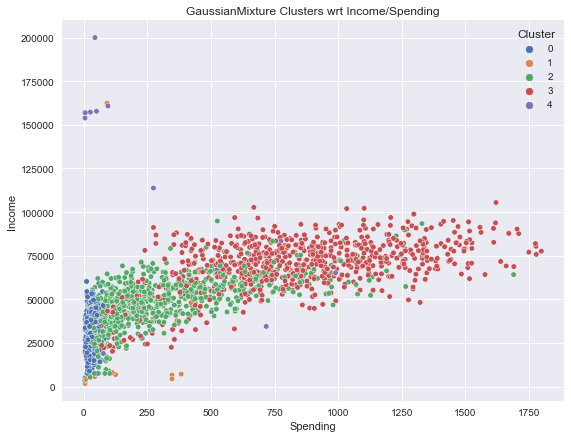

In [102]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(9, 7))  
sns.scatterplot(data=df_raw, x='Total_Spendage', y='Income', hue=gm_preds, palette='deep', ax=ax, s=30)
ax.set_title(f'GaussianMixture Clusters wrt Income/Spending')
ax.set_ylabel('Income')
ax.set_xlabel('Spending')
ax.legend(title='Cluster')
plt.show()

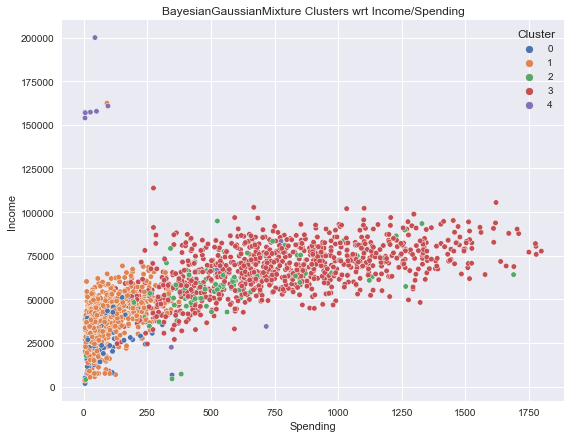

In [103]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(9, 7))  
sns.scatterplot(data=df_raw, x='Total_Spendage', y='Income', hue=bgm_preds, palette='deep', ax=ax, s=30)
ax.set_title(f'BayesianGaussianMixture Clusters wrt Income/Spending')
ax.set_ylabel('Income')
ax.set_xlabel('Spending')
ax.legend(title='Cluster')
plt.show()

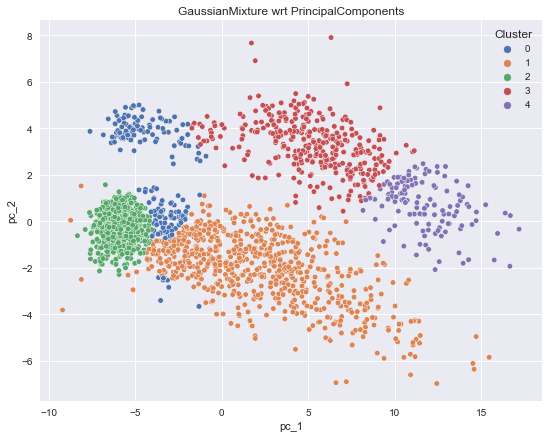

In [104]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(9, 7))  
sns.scatterplot(data=pca_df, x='pc_1', y='pc_2', hue=gm_pca_preds, palette='deep', ax=ax, s=30)
ax.set_title(f'GaussianMixture wrt PrincipalComponents')
ax.set_xlabel('pc_1')
ax.set_ylabel('pc_2')
ax.legend(title='Cluster')
plt.show()

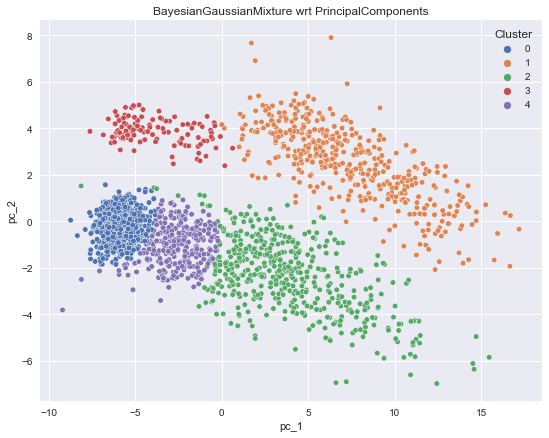

In [105]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(9, 7))  
sns.scatterplot(data=pca_df, x='pc_1', y='pc_2', hue=bgm_pca_preds, palette='deep', ax=ax, s=30)
ax.set_title(f'BayesianGaussianMixture wrt PrincipalComponents')
ax.set_xlabel('pc_1')
ax.set_ylabel('pc_2')
ax.legend(title='Cluster')
plt.show()